
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       138
           1       0.97      0.91      0.94       162

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



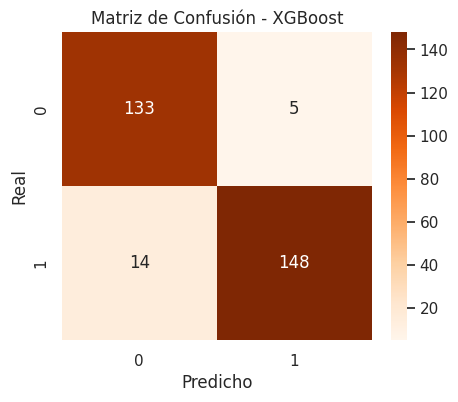

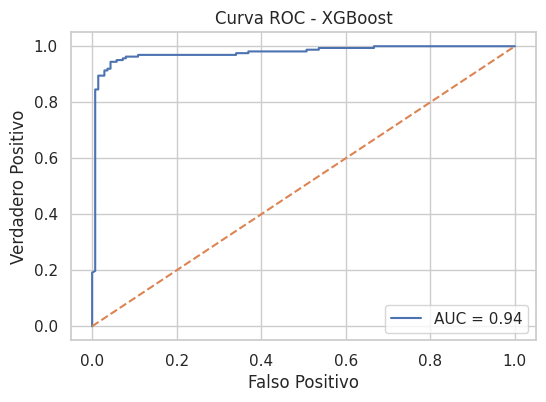


Mejores Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Precisión en Test con Mejor Modelo: 0.9466666666666667

Precisión Promedio con Validación Cruzada: 0.95


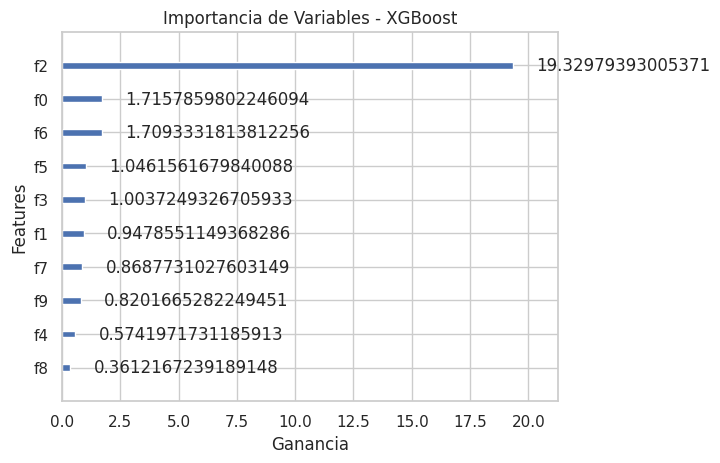

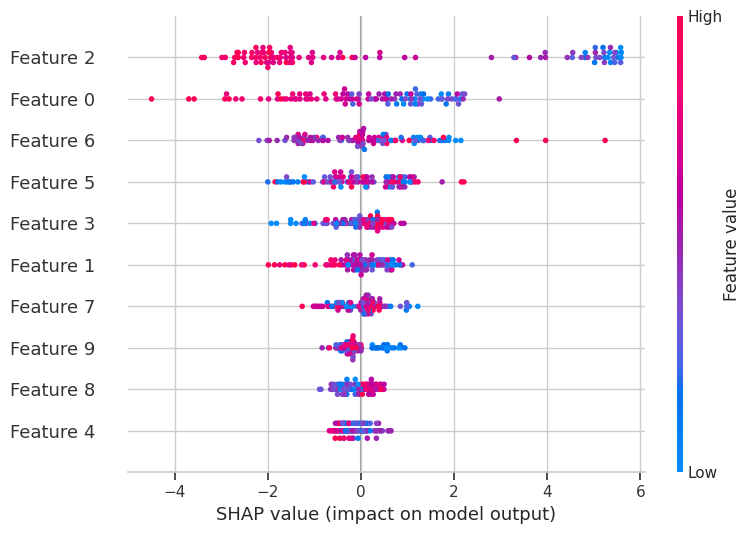

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

import xgboost as xgb
import shap
import warnings
warnings.filterwarnings("ignore")

# 1. Generar datos sintéticos
X, y = make_classification(n_samples=1000, n_features=10, n_informative=6,
                           n_redundant=2, n_clusters_per_class=1, random_state=42)

# 2. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Crear modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 4. Evaluar modelo
y_pred = xgb_model.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 5. Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadero Positivo")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

# 7. Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("\nMejores Hiperparámetros:", grid.best_params_)
print("Precisión en Test con Mejor Modelo:", accuracy_score(y_test, grid.best_estimator_.predict(X_test)))

# 8. Validación cruzada
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("\nPrecisión Promedio con Validación Cruzada:", np.mean(scores))

# 9. Importancia de variables
xgb.plot_importance(xgb_model, importance_type='gain', title='Importancia de Variables - XGBoost', xlabel='Ganancia')
plt.show()

# 10. SHAP para interpretabilidad
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, X_test[:100])
